# Train Model to play pong

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading and inspecting training data

In [2]:
dataset = np.load(file="traindata_v1.npy", encoding='bytes')

In [3]:
from collections import Counter
labels_counter = Counter(dataset[:,6].tolist())
print(labels_counter)

print("Prediction must be higher than: {}".format(labels_counter[0.0]/dataset.shape[0]))

Counter({0.0: 16034, 1.0: 2090, 2.0: 1946})
Prediction must be higher than: 0.798903836571998


## Create size invariant features
We will get the approximate width and height of the game window and divide vertical and horizontal features by these values so we get size invariant features so the model can perform nearly the same in any size.

In [4]:
def set_size_invariant_features(dataset):
    #Get max and min feature values of the entire dataset
    min_values = np.amin(dataset, axis=0)
    max_values = np.amax(dataset, axis=0)
    
    #We will set the width the difference between the bars horizontal positions max and min
    gwindow_width = max_values[4] - min_values[2]
    #We will set the height as the difference between the max and mins positions the ball has deslocated
    gwindow_height = max_values[1] - min_values[1]
    
    #Create vector to transform features to position invariant
    #We will divide horizontal features by the width and vertical features by the height
    pos_invariant_vector = np.array([
        gwindow_width, gwindow_height, #Ball position
        gwindow_width, gwindow_height, #Bar1 position
        gwindow_width, gwindow_height, #Bar2 position
        1 #datapoint label, stays the same
    ])
    
    return dataset/pos_invariant_vector

In [5]:
#dataset = set_size_invariant_features(dataset)

## Set up ball speed as a feature

In [6]:
def set_ball_speed(dataset):
    #Since we don't know the previous position of the first sample, we will have one less datapoint
    #Velocity(T) = Position(T) - Position(T-1)
    speed_datapoints = dataset[1:, :2] - dataset[0:-1, :2]
    #Insert new datapoints after the ball position features
    new_dataset = np.concatenate((dataset[1:, :2], speed_datapoints, dataset[1:, 2:]), axis=1)
    return new_dataset   

In [7]:
dataset = set_ball_speed(dataset)

## Creating model

In [8]:
tf.reset_default_graph()

n_features = 8

x_mean = tf.Variable(initial_value=[0]*n_features, trainable=False, dtype=tf.float32)
x_std = tf.Variable(initial_value=[1]*n_features, trainable=False, dtype=tf.float32)

x = tf.placeholder(dtype=tf.float32, shape=[None, n_features])
keep_prob = tf.placeholder(dtype=tf.float32)

x_norm = (x-x_mean)/x_std
    
y = tf.placeholder(dtype=tf.int32, shape=[None])
y_onehot = tf.one_hot(y, depth=3)
    
h1 = tf.layers.dense(x, 20, activation=tf.nn.relu)
#h1 = tf.nn.dropout(h1, keep_prob)

h2 = tf.layers.dense(h1, 20, activation=tf.nn.relu)
#h2 = tf.nn.dropout(h2, keep_prob)

h3 = tf.layers.dense(h2, 10, activation=tf.nn.relu)
#h3 = tf.nn.dropout(h3, keep_prob)
    
logits = tf.layers.dense(h3, 3, activation=None)

sc = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_onehot)

cost = tf.reduce_mean(sc)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y_onehot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

#Optimizer
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

In [9]:
def balance_data_labels():
    extra_data_inputs = list()
    extra_data_labels = list()

    for d_input, d_label in zip(train_data_inputs, train_data_labels):
        if d_label[1] == 1 or d_label[2] == 1:
            for _ in range(5):
                extra_data_inputs.append(d_input.copy())
                extra_data_labels.append(d_label.copy())

    extra_data_inputs = np.array(extra_data_inputs)
    extra_data_labels = np.array(extra_data_labels)

    print(extra_data_inputs.shape)
    print(extra_data_labels.shape)

    enhanced_train_data_inputs = np.concatenate((train_data_inputs, extra_data_inputs), axis=0)
    enhanced_train_data_labels = np.concatenate((train_data_labels, extra_data_labels), axis=0)

    print(enhanced_train_data_inputs.shape)
    print(enhanced_train_data_labels.shape)

## Normalize data

In [10]:
def normalize_data():
    data_mean = np.mean(enhanced_train_data_inputs, axis=0)
    data_std = np.std(enhanced_train_data_inputs, axis=0)

    norm_enhanced_train_data_inputs = (enhanced_train_data_inputs - data_mean) / data_std

## Get norm factors

In [11]:
data_mean = np.mean(dataset, axis=0)
data_std = np.std(dataset, axis=0)

## Split dataset into training validation and test set

In [12]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dataset, test_size=0.4, random_state=None)
valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=None)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(12041, 9)
(4014, 9)
(4014, 9)


In [13]:
print(train_data[:1, :-1])
print(train_data[:1, -1])

[[ 662.    71.   169.5   50.5   51.    91.   662.    71. ]]
[ 1.]


## Run model

Epoch: 0 Cost: 18.070817947387695
Accuracy: 0.18485301733016968

Epoch: 500 Cost: 0.5203962326049805
Accuracy: 0.8026905655860901

Epoch: 1000 Cost: 0.5003190040588379
Accuracy: 0.8026905655860901

Epoch: 1500 Cost: 0.48165735602378845
Accuracy: 0.8148978352546692

Epoch: 2000 Cost: 0.4446142017841339
Accuracy: 0.8226208090782166

Epoch: 2500 Cost: 0.4170750677585602
Accuracy: 0.8241155743598938

Epoch: 3000 Cost: 0.39504796266555786
Accuracy: 0.8373193740844727

Epoch: 3500 Cost: 0.37672722339630127
Accuracy: 0.8405580520629883

Epoch: 4000 Cost: 0.36390987038612366
Accuracy: 0.8420528173446655

Epoch: 4500 Cost: 0.3564572334289551
Accuracy: 0.8435475826263428

Epoch: 5000 Cost: 0.3530547022819519
Accuracy: 0.8467862606048584

Epoch: 5500 Cost: 0.35096168518066406
Accuracy: 0.8487792611122131

Epoch: 6000 Cost: 0.3487280607223511
Accuracy: 0.847533643245697

Epoch: 6500 Cost: 0.3478448987007141
Accuracy: 0.8490284085273743

Epoch: 7000 Cost: 0.3466431796550751
Accuracy: 0.851519703865

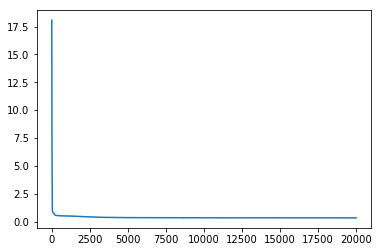

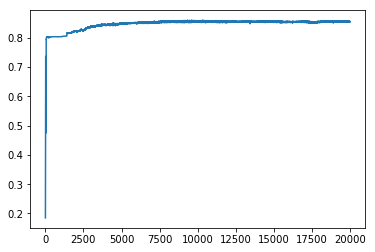

Final accuracy: 0.8522670865058899


In [14]:
from random import shuffle
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib

epochs = 20000
keep_prob_value = 1

cost_list = []
acc_list = []

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    #Assign norm factors values
    #sess.run(tf.assign(x_mean, data_mean[:-1]))
    #sess.run(tf.assign(x_std, data_std[:-1]))

    for e in range(epochs):
        
        #Run optimizer and compute cost
        x_train = train_data[:, :-1]
        y_train = train_data[:, -1]
                
        cost_value, _ = sess.run([cost, optimizer], feed_dict={
            x: x_train,
            y: y_train,
            keep_prob: keep_prob_value
        })

        if e % 500 == 0:
            print("Epoch: {} Cost: {}".format(e, cost_value))

        cost_list.append(cost_value)

        
        
        #Run accuracy and compute its value
        x_valid = valid_data[:, :-1]
        y_valid = valid_data[:, -1]
        
        acc_value = sess.run(accuracy, feed_dict={
            x: x_valid,
            y: y_valid,
            keep_prob: 1
        })
                
        acc_list.append(acc_value)

        if e % 500 == 0:
            print("Accuracy: {}".format(acc_value))
            print("")
            
            
     
    #Calculate final accuracy
    x_test = test_data[:, :-1]
    y_test = test_data[:, -1]
    
    final_acc, predictions = sess.run([accuracy, logits], feed_dict={
            x: x_test,
            y: y_test,
            keep_prob: 1
        })
    
    #print(predictions)

             
    plt.plot(cost_list)
    plt.show()
    plt.plot(acc_list)
    plt.show()
    print("Final accuracy: {}".format(final_acc))
            
    saver = tf.train.Saver()
    save_path = saver.save(sess, "./model/model_v21_nodrop.ckpt")

In [15]:
print(Counter(np.argmax(predictions, axis=1).tolist()))
print(Counter(y_test))

Counter({0: 3411, 1: 318, 2: 285})
Counter({0.0: 3177, 1.0: 441, 2.0: 396})
